In [14]:
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from glob import glob

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
print('pytorch version:', torch.__version__)
global_device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', global_device)
from torch.utils.data import DataLoader, random_split, Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

import pytorch_lightning as pl
from torchmetrics.classification import MultilabelAveragePrecision

pytorch version: 2.2.0.dev20231027+cu121
Device: cuda:0


In [3]:
# Matplotlib settings
import matplotlib
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter

titlesize = 20
labelsize = 16
legendsize = labelsize
xticksize = 14
yticksize = xticksize

matplotlib.rcParams['legend.markerscale'] = 1.5     # the relative size of legend markers vs. original
matplotlib.rcParams['legend.handletextpad'] = 0.5
matplotlib.rcParams['legend.labelspacing'] = 0.4    # the vertical space between the legend entries in fraction of fontsize
matplotlib.rcParams['legend.borderpad'] = 0.5       # border whitespace in fontsize units
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['font.serif'] = 'Times New Roman'
matplotlib.rcParams['axes.labelsize'] = labelsize
matplotlib.rcParams['axes.titlesize'] = titlesize

matplotlib.rc('xtick', labelsize=xticksize)
matplotlib.rc('ytick', labelsize=yticksize)
matplotlib.rc('legend', fontsize=legendsize)

matplotlib.rc('font', **{'family':'serif'})

# Data loading

In [5]:
df_trainval = pd.read_csv('data/train.csv')
df_train, df_val = train_test_split(df_trainval, test_size=0.2)
df_train['tags'] = df_train['tags'].apply(lambda x: np.array(list(map(int, x.split(',')))))
df_val['tags'] = df_val['tags'].apply(lambda x: np.array(list(map(int, x.split(',')))))

df_test = pd.read_csv('data/test.csv')

In [16]:
global_idx2embeds = {} # {idx: np.ndarray[n, 768])}
for npy_file in tqdm(glob('data/track_embeddings/*')):
    track_idx = int(npy_file.split('\\')[1].split('.')[0])
    embeds = np.load(npy_file)
    global_idx2embeds[track_idx] = embeds

100%|██████████| 76714/76714 [01:09<00:00, 1101.45it/s]


In [17]:
global_pos_weights = np.ones(256)
num_of_tags = np.zeros(256)
for tags in df_train['tags'].to_list():
    onehot_tags = np.zeros(256)
    onehot_tags[tags] = 1
    num_of_tags += onehot_tags
global_pos_weights = (len(df_train) - num_of_tags) / num_of_tags
global_pos_weights_log = np.log(global_pos_weights)
global_pos_weights_sqrt = np.sqrt(global_pos_weights)

Text(0, 0.5, 'Sqrt(Pos Weight)')

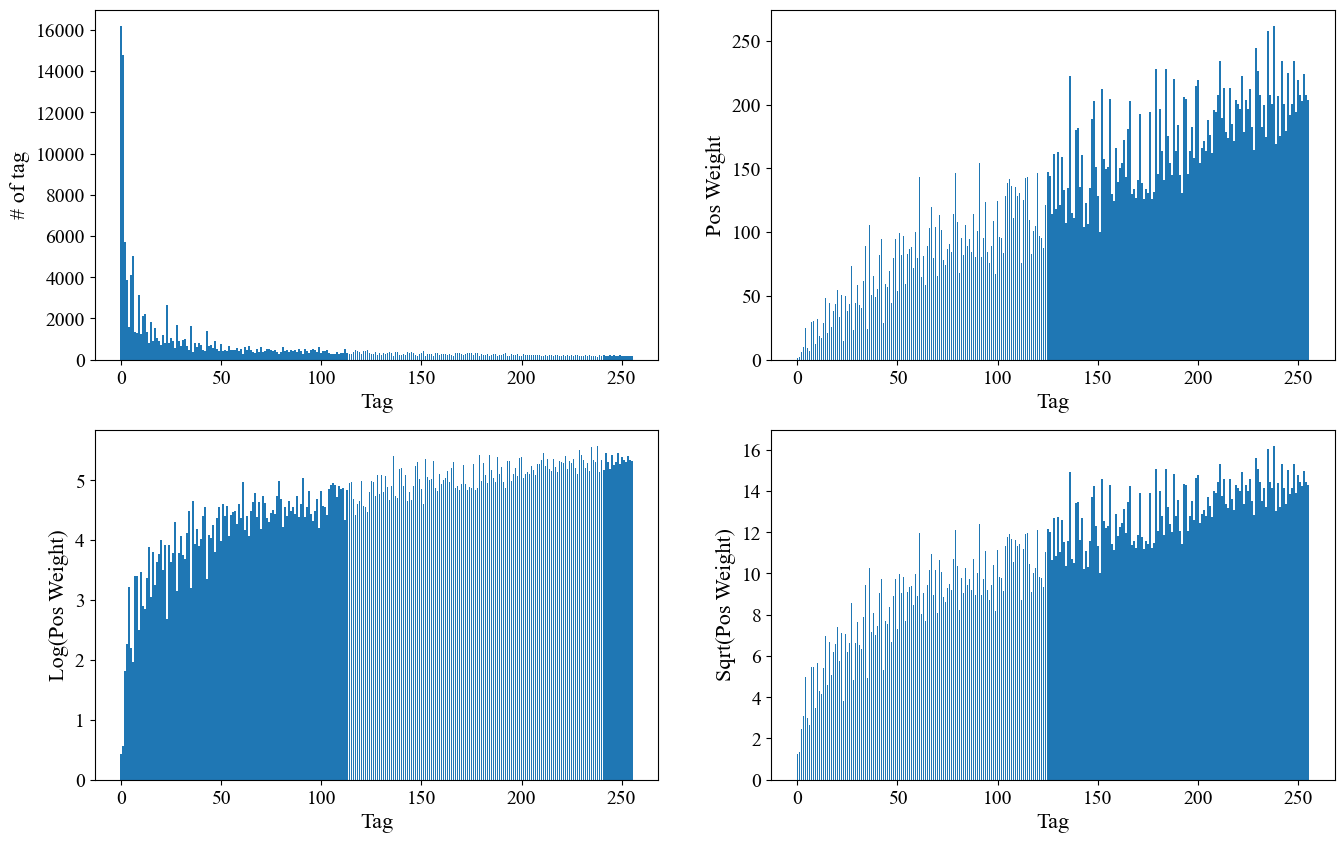

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs[0, 0].bar(range(0, 256), num_of_tags)
axs[0, 0].set_xlabel('Tag')
axs[0, 0].set_ylabel('# of tag')

axs[0, 1].bar(range(0, 256), global_pos_weights)
axs[0, 1].set_xlabel('Tag')
axs[0, 1].set_ylabel('Pos Weight')

axs[1, 0].bar(range(0, 256), global_pos_weights_log)
axs[1, 0].set_xlabel('Tag')
axs[1, 0].set_ylabel('Log(Pos Weight)')

axs[1, 1].bar(range(0, 256), global_pos_weights_sqrt)
axs[1, 1].set_xlabel('Tag')
axs[1, 1].set_ylabel('Sqrt(Pos Weight)')

In [19]:
class TrackDataset(torch.utils.data.Dataset):
    def __init__(self, df_tags, test=False):
        self.df_tags = df_tags
        self.test = test

    def __len__(self):
        return len(self.df_tags)

    def __getitem__(self, idx):
        track_idx = self.df_tags.iloc[idx]['track']
        embeds = global_idx2embeds[track_idx]
        if self.test:
            return track_idx, embeds
        labels_onehot = np.zeros(256)
        labels_onehot[self.df_tags.iloc[idx]['tags']] = 1
        return track_idx, embeds, labels_onehot

In [59]:
def collate(batch):
    track_idxs = torch.IntTensor(np.vstack([triplet[0] for triplet in batch]))
    embeds_list = [torch.FloatTensor(triplet[1]).to(global_device) for triplet in batch]
    labels_onehot = torch.FloatTensor(np.vstack([triplet[2] for triplet in batch])).to(global_device)
    return track_idxs, embeds_list, labels_onehot

def collate_test(batch):
    track_idxs = torch.IntTensor(np.vstack([triplet[0] for triplet in batch]))
    embeds_list = [torch.FloatTensor(triplet[1]).to(global_device) for triplet in batch]
    return track_idxs, embeds_list

batch_size = 256

dataset_train = TrackDataset(df_train)
dataloader_train = DataLoader(dataset_train, batch_size, shuffle=True, collate_fn=collate)

dataset_val = TrackDataset(df_val)
dataloader_val = DataLoader(dataset_val, batch_size, shuffle=False, collate_fn=collate)

dataset_test = TrackDataset(df_test, test=True)
dataloader_test = DataLoader(dataset_test, batch_size, shuffle=False, collate_fn=collate_test)

In [66]:
class TrackToTags(pl.LightningModule):
    def __init__(self, num_classes=256, input_dim=768, hidden_dim=512, pos_weights=None):
        super().__init__()
        self.num_classes = num_classes
        self.bn = nn.LayerNorm(hidden_dim)
        self.projector =  nn.Linear(input_dim, hidden_dim)
        self.lin = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )
        self.fc = nn.Linear(hidden_dim, num_classes)
        
        self.pos_weights = torch.FloatTensor(np.ones(256)).to(global_device)
        if pos_weights:
            self.pos_weights = torch.FloatTensor(pos_weights).to(global_device)
        self.loss = nn.BCEWithLogitsLoss(pos_weight=self.pos_weights)
        
        # self.metric = MultilabelAveragePrecision(num_labels=256)
        self.metric = average_precision_score
        self._transit_val = {'preds': [], 'labels': []}
        
    def forward(self, embeds_list):
        x = [self.projector(x) for x in embeds_list]
        x = [v.mean(0).unsqueeze(0) for v in x]
        x = self.bn(torch.cat(x, dim = 0))
        x = self.lin(x)
        outs = self.fc(x)
        return outs

    def training_step(self, batch, batch_idx):
        track_idxs, embeds_list, labels_onehot = batch
        pred_logits = self(embeds_list)
        loss = self.loss(pred_logits, labels_onehot)
        self.log("train/loss", loss, prog_bar=True)
        
#         pred_probs = torch.sigmoid(pred_logits)
#         ap = self.metric(pred_probs, labels_onehot.int())
#         self.log("train_ap", ap, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        track_idxs, embeds_list, labels_onehot = batch
        pred_logits = self(embeds_list)
        loss = self.loss(pred_logits, labels_onehot)
        self.log("val/loss", loss, prog_bar=True)
        
        pred_probs = torch.sigmoid(pred_logits)
        self._transit_val['labels'].append(np.array(labels_onehot.int().cpu()))
        self._transit_val['preds'].append(np.array(pred_probs.cpu()))

    def on_validation_epoch_end(self):
        preds = np.vstack(self._transit_val['preds'])
        labels = np.vstack(self._transit_val['labels'])
        ap = self.metric(labels, preds)
        self.log('val/epoch_ap', ap, prog_bar=True)
        self._transit_val['labels'] = []
        self._transit_val['preds'] = []

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.5)
        
        return {"optimizer": optimizer,
                "lr_scheduler": {
                                "scheduler": scheduler,
                                "interval": "epoch",
                                "frequency": 10
                                },
               }

In [67]:
trainer = pl.Trainer(accelerator="gpu", devices=1, val_check_interval=1.0, max_epochs=20, log_every_n_steps=100)
model = TrackToTags()
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | bn        | LayerNorm         | 1.0 K 
1 | projector | Linear            | 393 K 
2 | lin       | Sequential        | 526 K 
3 | fc        | Linear            | 131 K 
4 | loss      | BCEWithLogitsLoss | 0     
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.210     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 160/160 [00:51<00:00,  3.08it/s, v_num=3, train/loss=0.0427, val/loss=0.046, val/epoch_ap=0.208] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 160/160 [00:52<00:00,  3.07it/s, v_num=3, train/loss=0.0427, val/loss=0.046, val/epoch_ap=0.208]


In [61]:
trainer = pl.Trainer(accelerator="gpu", devices=1, val_check_interval=1.0, max_epochs=31, log_every_n_steps=100)
trainer.fit(model, dataloader_train, dataloader_val)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | bn        | LayerNorm         | 1.0 K 
1 | projector | Linear            | 393 K 
2 | lin       | Sequential        | 526 K 
3 | fc        | Linear            | 131 K 
4 | loss      | BCEWithLogitsLoss | 0     
------------------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.210     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 3: 100%|██████████| 160/160 [00:39<00:00,  4.04it/s, v_num=1, train/loss=0.0441, val/loss=0.0467, val/epoch_ap=0.288]

In [34]:
def predict(model, loader):
    model.to(global_device)
    model.eval()
    track_idxs = []
    predictions = []
    with torch.no_grad():
        for data in loader:
            track_idx, embeds = data
            embeds = [x.to(global_device) for x in embeds]
            pred_logits = model(embeds)
            pred_probs = torch.sigmoid(pred_logits)
            predictions.append(pred_probs.cpu().numpy())
            track_idxs.append(track_idx.numpy())
    predictions = np.vstack(predictions)
    track_idxs = np.vstack(track_idxs).ravel()
    return track_idxs, predictions

In [40]:
val_true = np.array([y[2] for y in dataset_val])
track_idxs_val, val_pred = predict(model, dataloader_val)
average_precision_score(val_true[2000:2256], val_pred[2000:2256])

0.3002778632457312

In [56]:
val_true.shape

(10227, 256)

In [54]:
average_precision_score(val_true[:100], val_pred[:100], default="macro")

0.2785028297836928

In [70]:
track_idxs, predictions = predict(model.to(global_device), dataloader_test)

In [72]:
predictions_df = pd.DataFrame([
    {'track': track, 'prediction': ','.join([str(p) for p in probs])}
    for track, probs in zip(track_idxs, predictions)
])
predictions_df.to_csv('prediction.csv', index=False)